WHY DO WE NEED TO DO SENTIMENT ANALYSIS

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string

In [2]:
# pip install wordcloud

In [3]:
import numpy as np
import sklearn
from wordcloud import wordcloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

In [4]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,classification_report


In [5]:
data = pd.read_csv(r"C:\Users\Asus\Downloads\netflix_reviews.csv\netflix_reviews.csv")

In [6]:
data.head()

,reviewId,userName,content,score,thumbsUpCount,reviewCreatedVersion,at,appVersion
0,1a7ce341-afc6-46da-9d08-793582e8ed3c,Ivan Berry,"I love 💕💕 to download it,,😭",5,0,NaN,2024-07-07 17:47:19,NaN
1,1bd445c3-7f36-4717-810a-63c5533207d0,Ryan Murray,Exceptional,5,1,8.121.2 build 22 50727,2024-07-07 12:31:53,8.121.2 build 22 50727
2,59f306cd-852b-4459-b24f-3e4436df8465,Shannon Bonacci,Can't even make it through a full episode of a...,2,2,8.121.2 build 22 50727,2024-07-07 05:21:45,8.121.2 build 22 50727
3,f21a1d8a-2b4c-4385-8aff-ca317a00e032,Katie Hutchinson,Great,5,0,8.26.0 build 11 40221,2024-07-06 19:47:34,8.26.0 build 11 40221
4,bdd267b4-4231-4a5d-b369-3ac9e5082fc5,Mirza Irfan,Your device is not part of the Netflix Househo...,1,0,8.120.0 build 10 50712,2024-07-05 17:09:39,8.120.0 build 10 50712


In [7]:
data.shape

(113619, 8)

In [8]:
data['content'].nunique()

112394

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113619 entries, 0 to 113618
Data columns (total 8 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   reviewId              113619 non-null  object
 1   userName              113617 non-null  object
 2   content               113617 non-null  object
 3   score                 113619 non-null  int64 
 4   thumbsUpCount         113619 non-null  int64 
 5   reviewCreatedVersion  96980 non-null   object
 6   at                    113619 non-null  object
 7   appVersion            96980 non-null   object
dtypes: int64(2), object(6)
memory usage: 6.9+ MB


In [10]:
data.describe()

,score,thumbsUpCount
count,113619.000000,113619.000000
mean,2.812681,10.433924
std,1.700560,101.009450
min,1.000000,0.000000
25%,1.000000,0.000000
50%,3.000000,0.000000
75%,5.000000,1.000000
max,5.000000,8032.000000


In [11]:
# there is variation between score & thumbsupcount

In [12]:
data.isnull().sum()

reviewId                    0
userName                    2
content                     2
score                       0
thumbsUpCount               0
reviewCreatedVersion    16639
at                          0
appVersion              16639
dtype: int64

In [13]:
# 2 username, 2 content, 16639 reviewcreatedversion, 16639 appversion is missing from dataset

In [14]:
data.duplicated().sum()

287

In [15]:
# there are 287 duplicated rows
# Lets have a look which are those

In [16]:
# Rempove Duplicate values

In [17]:
data = data.drop_duplicates()

In [18]:
data.duplicated().sum()

0

In [19]:
# DATA CLEANING

In [20]:
# Lets skip the features which do not contribute much in our model preparation

data = data[['content','score','thumbsUpCount','at']]

In [21]:
data.shape

(113332, 4)

In [22]:
# Lets fix the missing values-

# 1) 2 content are missing lets remove them as the quantity of missing values is very less

In [23]:
data[data['content'].isnull()]

,content,score,thumbsUpCount,at
3935,NaN,5,0,2024-05-21 16:56:29
4286,NaN,2,0,2024-05-19 13:52:42


In [24]:
data.drop([3935,4286],axis = 0, inplace = True)

data.shape

(113330, 4)

In [25]:
data[data['content'].isnull()]

,content,score,thumbsUpCount,at


In [26]:
# Here we found no null values now

In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 113330 entries, 0 to 113618
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   content        113330 non-null  object
 1   score          113330 non-null  int64 
 2   thumbsUpCount  113330 non-null  int64 
 3   at             113330 non-null  object
dtypes: int64(2), object(2)
memory usage: 4.3+ MB


In [28]:
print(data['score'].unique())
print("   ")
print(data['thumbsUpCount'].max())

[5 2 1 4 3]
   
8032


In [29]:
# here we see values of score ranges b/w 1 & 5, therefore it doesn't require int64 to store the values 
# we can reduce for for the sake of memory, similarly with thumbsupcount

# int64 is used to store large values

# >int16 : -32768 to +32767
# >int32 : -2147483648 to +2147483647
# >int64 : -9,223,372,036,854,775,808 to +9,223,372,036,854,775,807

In [30]:
data = data.astype({
    "score" : 'int16',
    'thumbsUpCount' : 'int16'
})

In [31]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 113330 entries, 0 to 113618
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   content        113330 non-null  object
 1   score          113330 non-null  int16 
 2   thumbsUpCount  113330 non-null  int16 
 3   at             113330 non-null  object
dtypes: int16(2), object(2)
memory usage: 3.0+ MB


In [32]:
# Here we see the memomry usage decreased

# We can notice the datatype of 'at' feature is object type, we should convert it into datetime to extract it properly

In [33]:
data['at'] = pd.to_datetime(data['at'])

In [34]:
print(data.head(2))
print("--------------------------------")

data.info()

                       content  score  thumbsUpCount                  at
0  I love 💕💕 to download it,,😭      5              0 2024-07-07 17:47:19
1                  Exceptional      5              1 2024-07-07 12:31:53
--------------------------------
<class 'pandas.core.frame.DataFrame'>
Index: 113330 entries, 0 to 113618
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   content        113330 non-null  object        
 1   score          113330 non-null  int16         
 2   thumbsUpCount  113330 non-null  int16         
 3   at             113330 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int16(2), object(1)
memory usage: 3.0+ MB


In [35]:
data.isnull().sum()

content          0
score            0
thumbsUpCount    0
at               0
dtype: int64

In [36]:
data.head()

,content,score,thumbsUpCount,at
0,"I love 💕💕 to download it,,😭",5,0,2024-07-07 17:47:19
1,Exceptional,5,1,2024-07-07 12:31:53
2,Can't even make it through a full episode of a...,2,2,2024-07-07 05:21:45
3,Great,5,0,2024-07-06 19:47:34
4,Your device is not part of the Netflix Househo...,1,0,2024-07-05 17:09:39


In [37]:
data['at'].min()

Timestamp('2018-09-12 07:22:12')

In [38]:
# lets create a seperate column for date and time

In [39]:
data['at'] = data['at'].dt.strftime('%Y')

In [40]:
data.head()

,content,score,thumbsUpCount,at
0,"I love 💕💕 to download it,,😭",5,0,2024
1,Exceptional,5,1,2024
2,Can't even make it through a full episode of a...,2,2,2024
3,Great,5,0,2024
4,Your device is not part of the Netflix Househo...,1,0,2024


In [41]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 113330 entries, 0 to 113618
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   content        113330 non-null  object
 1   score          113330 non-null  int16 
 2   thumbsUpCount  113330 non-null  int16 
 3   at             113330 non-null  object
dtypes: int16(2), object(2)
memory usage: 3.0+ MB


In [42]:
data.rename(columns= {'at':"Year",
                     'thumbsUpCount' : 'likes',
                     'content' : 'Reviews'},inplace = True)

In [43]:
data.duplicated().sum()

795

In [44]:
data = data.drop_duplicates()

In [45]:
data.duplicated().sum()

0

### DATA PREPROCESSING

#### Lets create a target variable say Positive, negative, neutral or happy, sad & neutral

In [46]:
def target_variable(rating):
    if rating >= 4:
        return 0
    elif rating == 3:
        return 1
    else:
        return 2

In [47]:
data['Emotion'] = data['score'].apply(target_variable)

In [48]:
data.head()

,Reviews,score,likes,Year,Emotion
0,"I love 💕💕 to download it,,😭",5,0,2024,0
1,Exceptional,5,1,2024,0
2,Can't even make it through a full episode of a...,2,2,2024,2
3,Great,5,0,2024,0
4,Your device is not part of the Netflix Househo...,1,0,2024,2


In [49]:
# here 0 represent positve/Happy
# 1 represent neutral
# 2 represent negative/sad

### TEXT PREPROCESSING

In [50]:
def remove_emoji(string):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

remove_emoji("game is on :) i'll be there hwvr🔥🔥")

"game is on :) i'll be there hwvr"

In [51]:
# !pip install contractions
# nltk.download('stopwords')

In [53]:
# So lets now preporocess the text
from nltk.stem import PorterStemmer
ps = PorterStemmer()

# Lemmatization generates the root form of word in meaningful word while stemming just reduces the word to its stem,
# it may or may not be meaningful.
# For speed we'll go with stemming also as we dont have to build any language specific model stemming 
# is best to be used in this case

In [54]:
def text_preprocessing(review):
    # html tag removal
    review = re.compile(r'<[^>]+>').sub('', review)
    # convert to lowercase
    review = review.lower()
    # punctuations removal
    review = review.translate(str.maketrans('','', string.punctuation))
    # deal with contractions
    review = contractions.fix(review)
    # remove digits
    review = ''.join([i for i in review if not i.isdigit()])
    # remove stopwords
    review = ' '.join([word for word in review.split() if word not in (stopwords.words('english'))])
    # stemming
    review = review.split()
    words = []
    for word in review:
        words.append(ps.stem(word))
    review = ' '.join(words)
    # remove emoji
    review = remove_emoji(review)
    #remove extra space
    review = ' '.join(review.split())
    return review

In [55]:
data['Reviews'] = data['Reviews'].apply(text_preprocessing)

In [56]:
data.head()

,Reviews,score,likes,Year,Emotion
0,love download it,5,0,2024,0
1,except,5,1,2024,0
2,cannot even make full episod show app crash cl...,2,2,2024,2
3,great,5,0,2024,0
4,devic part netflix household good polic way ev...,1,0,2024,2


### Visualization

In [57]:
data['Year'].value_counts()

Year
2020    28567
2021    17737
2019    16878
2024    16574
2022    15125
2023    12852
2018     4802
Name: count, dtype: int64

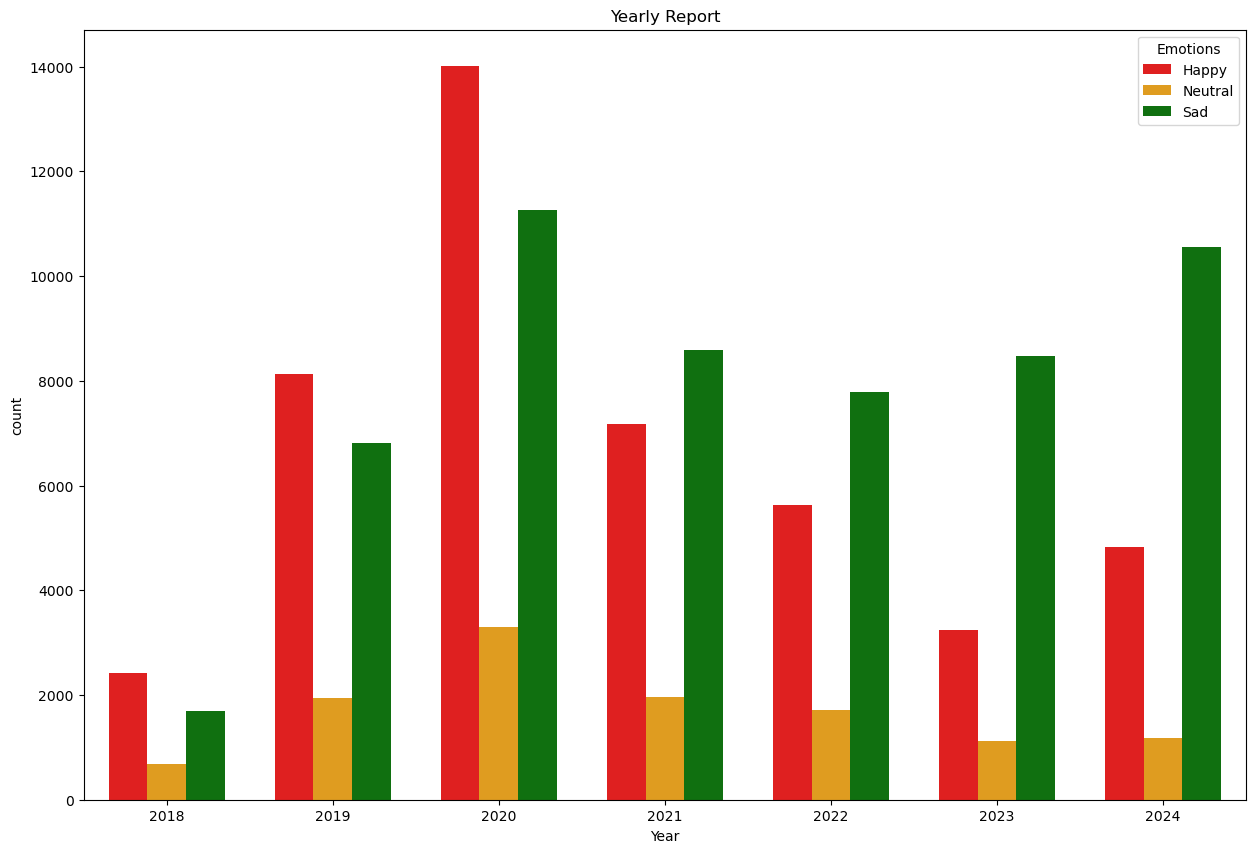

In [58]:
plt.figure(figsize=(15,10))
temp_data = data[['Year','Emotion']].sort_values(by='Year')
plot = sns.countplot(data=temp_data, x='Year', hue='Emotion', width=0.7, palette=['red', 'orange', 'green'])
plot.legend(title='Emotions', labels=['Happy', 'Neutral', 'Sad'])
plt.title('Yearly Report')
plt.show()

In [59]:
data['Emotion'].value_counts()

Emotion
2    55170
0    45435
1    11930
Name: count, dtype: int64

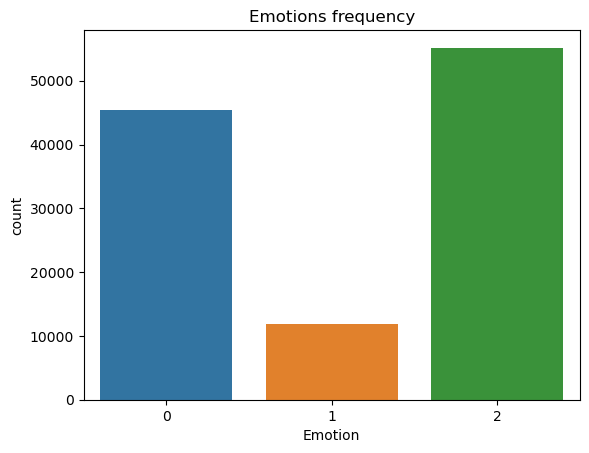

In [60]:
plot_1 = sns.countplot(x= 'Emotion', data = data)
# plot_1.legend(title='Emotions', labels=['Happy', 'Neutral', 'Sad'])
plt.title('Emotions frequency')
plt.show()

In [61]:
#Data Preprocessing

In [62]:
x = data.drop(['Emotion','Year'], axis = 1)
y = data['Emotion']

In [63]:
print('x_shape: ',x.shape, 'y_shape: ',y.shape)

x_shape:  (112535, 3) y_shape:  (112535,)


In [64]:
x.head()

,Reviews,score,likes
0,love download it,5,0
1,except,5,1
2,cannot even make full episod show app crash cl...,2,2
3,great,5,0
4,devic part netflix household good polic way ev...,1,0


In [65]:
from sklearn.model_selection import train_test_split
x_train,x_test, y_train,y_test = train_test_split(x,y,test_size = 0.20, random_state = 24) 

In [66]:
print('x_train: ',x_train.shape, 'x_test: ',x_test.shape)

print('y_train: ',y_train.shape, 'y_test: ',y_test.shape)

x_train:  (90028, 3) x_test:  (22507, 3)
y_train:  (90028,) y_test:  (22507,)


In [67]:
x_test.head()

,Reviews,score,likes
92654,cannot minim multitask turn screen,1,0
1965,poor respond,1,0
104564,sinc pay netflix good movi pay,5,0
103477,excel content stream,5,0
109077,goumd lot good show suppley thing interest dwindl,5,0


In [68]:
x_train.describe()

,score,likes
count,90028.000000,90028.000000
mean,2.804017,10.724686
std,1.698045,103.788014
min,1.000000,0.000000
25%,1.000000,0.000000
50%,3.000000,0.000000
75%,5.000000,1.000000
max,5.000000,8032.000000


In [69]:
# Lets Scale them up
# Normalizatiion (Min-Max Scaling) --[ends up scaling data between 0 and 1]
# Standardization ---[Centres data around the mean & scales to standard deviation of 1]

In [70]:
features = ['score','likes']

In [71]:
# df.hist(layout = (5,4),color ='blue',figsize= (15,12),grid = False)

In [72]:
# analyzing score distribution
# score_counts = data.Emotion.value_counts().sort_index()
# plt.figure(figsize=(8, 4))
# sns.barplot(x=score_counts.index, y=score_counts.values)
# plt.xlabel('Score')
# plt.ylabel('Count')
# plt.title('Distribution of Scores')
# plt.show()

In [73]:
# sentiment distribution
# plt.figure(figsize=(12, 6))
# sns.countplot(data=data, x='score', hue='Emotion')
# plt.xlabel('Score')
# plt.ylabel('Count')
# plt.title('Sentiment Distribution for Different Scores')
# plt.legend(title='Sentiment')
# plt.show()


In [74]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
MS = MinMaxScaler()
SC = StandardScaler()

In [75]:
x_train[features] = MS.fit_transform(x_train[features])

fit()	          Learn and estimate the parameters of the transformation

transform()	      Apply the learned transformation to new data

fit_transform()	  Learn the parameters and apply the transformation to new data

In [76]:
x_train.head()

,Reviews,score,likes
66239,love itbut icant search movi likeihop ican search,1.00,0.0
78578,phone support p pl fix good k tv watch phone l...,0.50,0.0
36713,problem app freez show download need uninstal ...,0.50,0.0
105313,cannot proceed bill use mobil number,0.25,0.0
108816,love itjust amaz love download part ad,1.00,0.0


In [77]:
x_test[features] = MS.transform(x_test[features])

In [78]:
x_test.head()

,Reviews,score,likes
92654,cannot minim multitask turn screen,0.0,0.0
1965,poor respond,0.0,0.0
104564,sinc pay netflix good movi pay,1.0,0.0
103477,excel content stream,1.0,0.0
109077,goumd lot good show suppley thing interest dwindl,1.0,0.0


# Word Embedding

In [79]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
cv = CountVectorizer(max_features = 4000)

In [80]:
X_train = x_train.values
X_test = x_test.values

In [81]:
X_train_text = X_train[ : , 0]
X_other_features = X_train[ : , 1: ]
X_transformed_text = cv.fit_transform(X_train_text).toarray()
X_train_transformed = np.concatenate((X_transformed_text, X_other_features), axis=1)

In [82]:
X_train_transformed

X_train = X_train_transformed
X_train.shape


(90028, 4002)

In [83]:
X_test_text = X_test[ : , 0]
X_other_features = X_test[ : , 1: ]
X_transformed_text = cv.transform(X_test_text).toarray()
X_test_transformed = np.concatenate((X_transformed_text, X_other_features), axis=1)

In [84]:
X_test = X_test_transformed
X_test.shape

(22507, 4002)

In [85]:
# Model Building

In [86]:
# pip install xgboost

In [87]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

GNB = GaussianNB()
MNB = MultinomialNB()
BNB = BernoulliNB()
knn = KNeighborsClassifier()
RFC = RandomForestClassifier(n_estimators=50, random_state=42)
ETC = ExtraTreesClassifier(n_estimators=50, random_state=42)

In [88]:
Classifiers = {
    'GaussianNB': GNB,
    'MultinomialNB': MNB,
    'BernoulliNB': BNB,
    'KNN':knn,
    'RandomForestClassifier':RFC,
    'ExtraTreesClassifier':ETC,
}

In [89]:
def train_model(clf):
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    p_score = precision_score(y_test, y_pred, average='weighted')
    kf_score = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=5)
    return str(score*100)+'%' , str(p_score*100)+'%'

In [92]:
import time
from sklearn.model_selection import cross_val_score

precision = []
accuracy = []
# start_time = time.time()                             

for model,classifier in Classifiers.items():
    acc,prec = train_model(classifier)
    accuracy.append(acc)
    precision.append(prec)
#     finish_time = time.time()
#     print("{} has been successfully evaluated. Total time taken is: {} seconds".format(model, (finish_time-start_time)))
#     start_time = finish_time

GaussianNB has been successfully evaluated. Total time taken is: 441.17897057533264 seconds
MultinomialNB has been successfully evaluated. Total time taken is: 292.6976041793823 seconds
BernoulliNB has been successfully evaluated. Total time taken is: 252.19318413734436 seconds
KNN has been successfully evaluated. Total time taken is: 1393.8360886573792 seconds
RandomForestClassifier has been successfully evaluated. Total time taken is: 75424.75206208229 seconds
ExtraTreesClassifier has been successfully evaluated. Total time taken is: 3081.0003345012665 seconds


In [93]:
Models_comparison = pd.DataFrame({'Model': Classifiers.keys(), 'Accuracy': accuracy, 'Precision': precision})
Models_comparison

,Model,Accuracy,Precision
0,GaussianNB,68.01883858355178%,73.79984823393879%
1,MultinomialNB,78.68218776380681%,78.10804742409142%
2,BernoulliNB,81.21473319411739%,80.73104764968375%
3,KNN,82.39658772826232%,81.01460158562986%
4,RandomForestClassifier,99.04029857377705%,99.04804889025657%
5,ExtraTreesClassifier,98.26720575820855%,98.30448683559406%
